# YOLO on PYNQ-Z1 and Movidius NCS: Webcam example
To run this notebook, you need to connect a USB webcam to the PYNQ-Z1 and a monitor to the HDMI output. You'll already need a powered USB hub for the Movidius NCS, so you should have a spare port for the webcam.
### Load required packages

In [1]:
from mvnc import mvncapi as mvnc
import cv2
import numpy as np
import time
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
import yolo_ncs,ncs
import PIL.Image
%matplotlib inline

# Load the base overlay
base = BaseOverlay("base.bit")

### Configure the webcam
To get a decent frame rate, we use a webcam resolution of 640x480 so that resizing to 448x448 for the YOLO network is reasonably fast. Note that OpenCV uses BGR, but the YOLO network needs RGB, so we'll have to swap the colors around before sending images to YOLO.

In [2]:
# Webcam resolution
frame_in_w = 640
frame_in_h = 480

# Configure webcam - note that output images will be BGR
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);

print("Capture device is open: " + str(videoIn.isOpened()))

Capture device is open: True


### Configure the HDMI output

In [3]:
hdmi_out = base.video.hdmi_out

# Configure the HDMI output to the same resolution as the webcam input
mode = VideoMode(frame_in_w,frame_in_h,24)
hdmi_out.configure(mode, PIXEL_BGR)

# Start the HDMI output
hdmi_out.start()

### Take a photo with the webcam

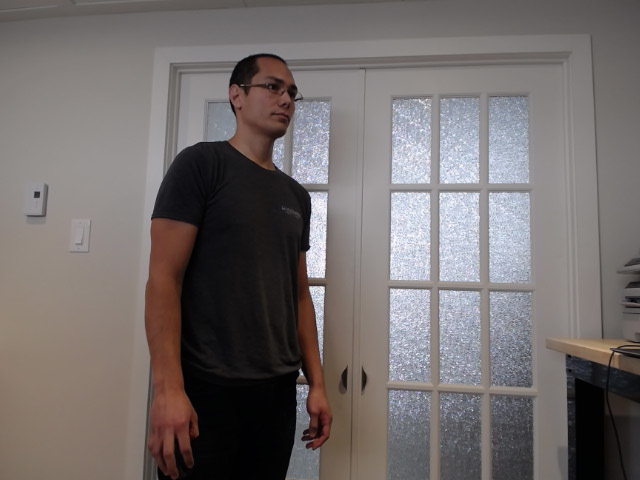

In [4]:
ret, frame = videoIn.read()
if (not ret):      
    raise RuntimeError("Failed to read from camera.")

# Convert BGR image to RGB (required by YOLO and PIL)
frame = frame[:,:,(2,1,0)]

# Resize the image to the size required by YOLO network (448x448)
small_frame = cv2.resize(frame, dsize=(448, 448), interpolation=cv2.INTER_CUBIC)
ncs_frame = small_frame.copy()/255.0

# Show the image in the Jupyter notebook
img = PIL.Image.fromarray(frame)
img

### Open the Movidius NCS

In [5]:
# Open the Movidius NCS device
ncsdev = ncs.MovidiusNCS()

# Load the graph file
if ncsdev.load_graph('../graph'):
    print('Graph file loaded to Movidius NCS')

Graph file loaded to Movidius NCS


### Send image to NCS

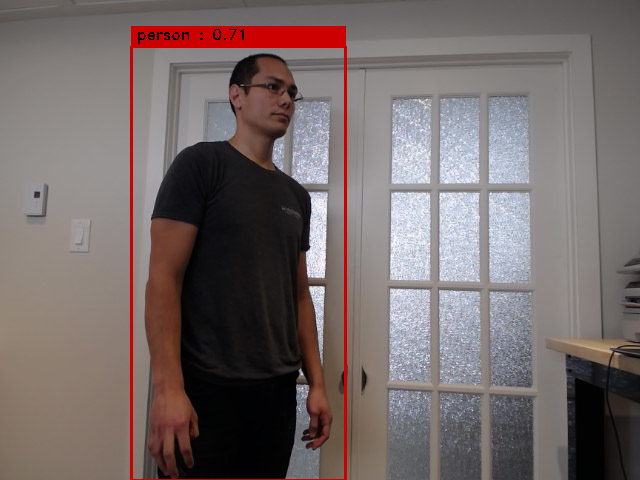

In [6]:
ncsdev.graph.LoadTensor(ncs_frame.astype(np.float16), 'user object')
out, userobj = ncsdev.graph.GetResult()

# Interpret results and draw boxes on the image
results = yolo_ncs.interpret_output(out.astype(np.float32), frame.shape[1], frame.shape[0]) # fc27 instead of fc12 for yolo_small
img_res = yolo_ncs.draw_boxes(frame, results, frame.shape[1], frame.shape[0])

# Display labelled image in Jupyter notebook
img = PIL.Image.fromarray(img_res)
img

### Webcam to HDMI pass-through (without YOLO)

In [7]:
n_frames = 2000

start_time = time.time()

for _ in range(n_frames):
    # Get a frame from the webcam
    ret, frame = videoIn.read()
    
    # Copy the input frame to the output frame
    frame_out = hdmi_out.newframe()
    frame_out[:,:,:] = frame[:,:,:]
    hdmi_out.writeframe(frame_out)

end_time = time.time()

print('Runtime:',end_time-start_time,'FPS:',n_frames/(end_time-start_time))

Runtime: 72.0343644618988 FPS: 27.764526208291343


### Webcam to HDMI with YOLO

In [8]:
n_frames = 200

start_time = time.time()

for _ in range(n_frames):
    # Get a frame from the webcam
    ret, frame = videoIn.read()
    
    # Resize to the frame size required by YOLO network (448x448) and convert to RGB
    small_frame = cv2.resize(frame[:,:,(2,1,0)], dsize=(448, 448), interpolation=cv2.INTER_CUBIC)
    ncs_frame = small_frame.copy()/255.0
    
    # Send the frame to the NCS
    ncsdev.graph.LoadTensor(ncs_frame.astype(np.float16), 'user object')
    out, userobj = ncsdev.graph.GetResult()
    
    # Interpret results and draw the boxes on the image
    results = yolo_ncs.interpret_output(out.astype(np.float32), frame.shape[1], frame.shape[0]) # fc27 instead of fc12 for yolo_small
    img_res = yolo_ncs.draw_boxes(frame, results, frame.shape[1], frame.shape[0])

    # Copy labelled image into output frame
    frame_out = hdmi_out.newframe()
    frame_out[:,:,:] = img_res[:,:,:]
    hdmi_out.writeframe(frame_out)

end_time = time.time()

print('Runtime:',end_time-start_time,'FPS:',n_frames/(end_time-start_time))

Runtime: 86.11693739891052 FPS: 2.3224235097163386


### Close the NCS device

In [9]:
ncsdev.close()

### Release the webcam and HDMI output

In [10]:
videoIn.release()
hdmi_out.stop()
del hdmi_out